### Inference on a larger data set ###

In [1]:
import sys
import os
import numpy as np
import json
import pandas as pd
import logging
from pathlib import Path
from matplotlib import pyplot as plt
import albumentations as alb
import itertools

logger = logging.getLogger(__name__)

# PyTorch
import torch
from torch.utils.data import DataLoader
from torchvision import ops

# Hugging Face Library
from transformers import RTDetrV2ForObjectDetection, RTDetrImageProcessor

%load_ext autoreload
%autoreload 2
import computervision
from computervision.imageproc import is_image, ImageData, clipxywh, xyxy2xywh, xywh2xyxy
from computervision.imageproc import plot_boxes
from computervision.datasets import DETRdataset, get_gpu_info
from computervision.transformations import AugmentationTransform
from computervision.performance import DetectionMetrics
from computervision.inference import DetrInference

print(f'Project version: {computervision.__version__}')
print(f'Python version:  {sys.version}')

Project version: v0.0.2
Python version:  3.12.3 (main, Jun 18 2025, 17:59:45) [GCC 13.3.0]


In [2]:
# Check GPU availability
device, device_str = get_gpu_info()
print(f'Current device {device}')

CUDA available: True
Number of GPUs found:  1
Current device ID: 0
GPU device name:   NVIDIA GeForce RTX 3060 Laptop GPU
PyTorch version:   2.8.0a0+34c6371d24.nv25.08
CUDA version:      13.0
CUDNN version:     91200
Device for model training/inference: cuda:0
Current device cuda:0


In [68]:
# Directories and files HSDM DATA 
dataset = 'dataset_object_240921'
annotations_file_name = 'objectdata_240921_clean_ide.parquet'
image_dir = os.path.join(os.environ.get('DATA'), dataset)
annotations_file = os.path.join(image_dir, annotations_file_name)

file_col = 'multi_file'
bbox_col = 'bbox'
pos_col = 'pos'

model_name = 'rtdetr_roboflow_251005_01'
model_dir = os.path.join(os.environ.get('DATA'), 'model', model_name)
checkpoint = 'checkpoint-3800'
checkpoint_dir = os.path.join(model_dir, checkpoint)

results_dir = os.path.join(model_dir, 'results')
Path(results_dir).mkdir(parents=True, exist_ok=True)

In [3]:
# Directories and files
dataset = 'dataset_object_roboflow_240930'
annotations_file_name = 'roboflow_240930_dset.parquet'
image_dir = os.path.join(os.environ.get('DATA'), dataset)
annotations_file = os.path.join(image_dir, annotations_file_name)

file_col = 'multi_file'
bbox_col = 'bbox'
pos_col = 'pos'

model_name = 'rtdetr_roboflow_251005_01'
model_dir = os.path.join(os.environ.get('DATA'), 'model', model_name)
checkpoint = 'checkpoint-3800'
checkpoint_dir = os.path.join(model_dir, checkpoint)

results_dir = os.path.join(model_dir, 'results')
Path(results_dir).mkdir(parents=True, exist_ok=True)

In [69]:
# Load the model configuration files
config_file = os.path.join(model_dir, f'{model_name}.json')
with open(config_file, mode='r') as fl:
    model_config = json.load(fl)
display(sorted(list(model_config.keys())))

# Annotations for the test set
df = pd.read_parquet(annotations_file).astype({'pos': int})
# df = df.loc[df['dset'].isin(['val', 'test'])].reset_index(drop=True)

# Labels
# The PyTorch dataset needs a label column
id2label = model_config.get('id2label')
id2label = {int(k): int(v) for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}
df = df.assign(label=df[pos_col].apply(lambda pos: label2id.get(pos)))

# Image id
file_list = list(df[file_col].unique())
file2id = dict(zip(file_list, range(len(file_list))))
id2file = {v: k for k, v in file2id.items()}
df = df.assign(image_id=df[file_col].apply(lambda file: file2id.get(file)))
display(df.head(2))

['bbox_format', 'id2label', 'model_info', 'processor_params', 'training_args']

,multi_file,pos,box_score,bbox,PatientIDE,annotator_name,d1,d2,d3,d4,d5,d6,disease,quality,single_file,label,image_id
0,457fecca_20180208_00.png,20,0.565375,"[0.0, 453.28, 267.08, 865.22]",457fecca,Maria,2,2,2,3,2,0,stable,yes,box_457fecca_20180208_00_00.png,19,0
1,8fb6f1a1_20220322_00.png,3,0.989590,"[0.0, 69.95, 501.94, 892.3]",8fb6f1a1,Maria,3,2,3,3,2,3,healthy,yes,box_8fb6f1a1_20220322_00_02.png,2,1


### Create the dataset ###

In [86]:
data_select = df.loc[df[file_col].isin(file_list[:100])]

dataset = DETRdataset(data=data_select,
                      image_processor=processor,
                      image_dir=image_dir,
                      file_name_col=file_col,
                      label_id_col=None,
                      bbox_col=None,
                      transforms=[alb.NoOp()])

batch_size = 4

# Calculate the number of batches in the data set
n_images = len(dataset)
n_batches = int(np.floor(n_images / batch_size))
rest = int(n_images - (n_batches * batch_size))
if rest > 0:
    n_batches += 1
print(f'Number of images in data set:  {n_images}')
print(f'Batch size:                    {batch_size}')
print(f'Number of batches in data set: {n_batches}')

Number of images in data set:  100
Batch size:                    4
Number of batches in data set: 25


### Predict on the data set ###

In [87]:
detr = DetrInference(device=device, checkpoint_path=checkpoint_dir, batch_size=batch_size)
pred_df = detr.predict_on_dataset(dataset=dataset, threshold=0.05)

KeyError: None

In [74]:
# Add the correct position label
pred_df = pred_df.assign(pos=pred_df['category_id'].apply(lambda cat: id2label.get(cat)))
pred_df = pred_df.assign(file=pred_df['image_id'].apply(lambda idx: id2file.get(idx)))
display(pred_df.head())

,image_id,image_width,image_height,batch,category_id,bbox,score,area,pos,file
0,0,1200,854,0,18,"[193, 245, 788, 363]",0.965514,286044,19.0,457fecca_20180208_00.png
1,0,1200,854,0,19,"[0, 315, 300, 292]",0.963342,87600,20.0,457fecca_20180208_00.png
2,0,1200,854,0,12,"[2, 1, 301, 280]",0.104986,84280,13.0,457fecca_20180208_00.png
3,0,1200,854,0,19,"[193, 245, 788, 363]",0.075424,286044,20.0,457fecca_20180208_00.png
4,0,1200,854,0,17,"[193, 245, 788, 363]",0.072885,286044,18.0,457fecca_20180208_00.png


457fecca_20180208_00.png


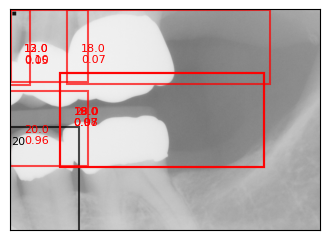

8fb6f1a1_20220322_00.png


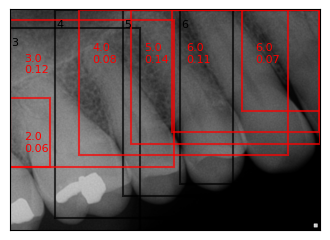

8fb6f1a1_20220322_01.png


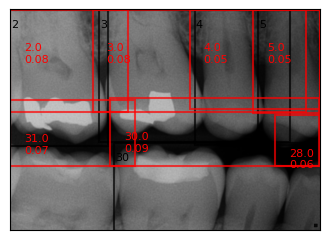

8fb6f1a1_20220322_02.png


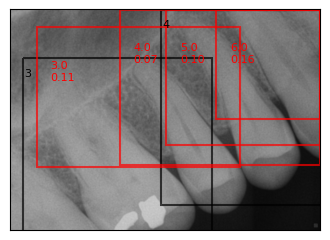

8fb6f1a1_20220322_03.png


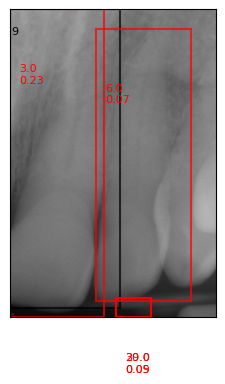

8fb6f1a1_20220322_04.png


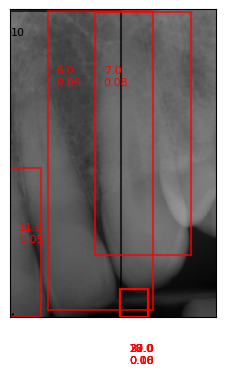

8fb6f1a1_20220322_05.png


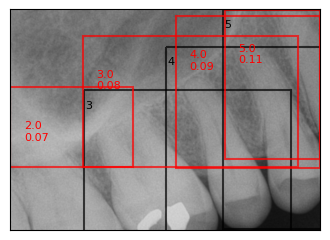

8fb6f1a1_20220322_06.png


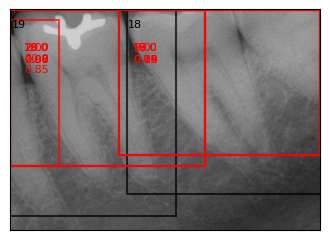

8fb6f1a1_20220322_07.png


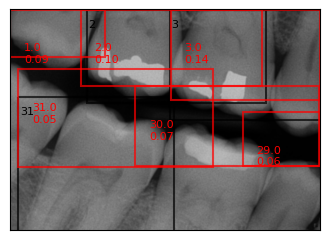

8fb6f1a1_20220322_08.png


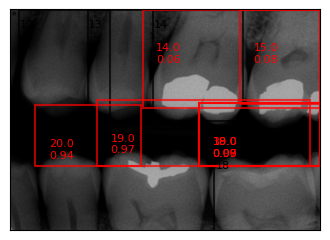

8fb6f1a1_20220322_09.png


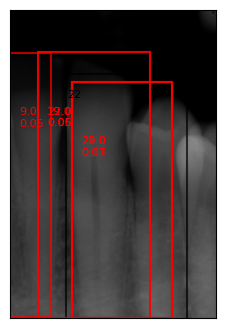

8fb6f1a1_20220322_10.png


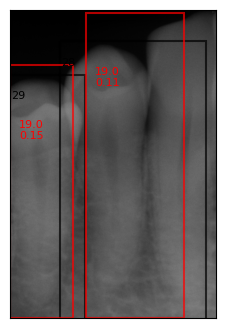

8fb6f1a1_20220322_11.png


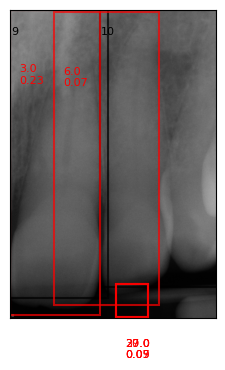

8fb6f1a1_20220322_12.png


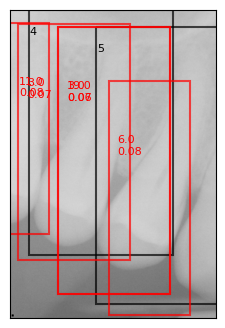

8fb6f1a1_20220322_13.png


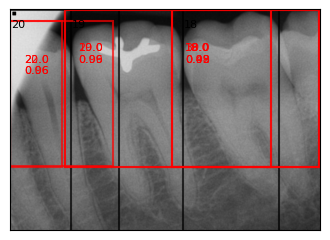

8fb6f1a1_20220322_14.png


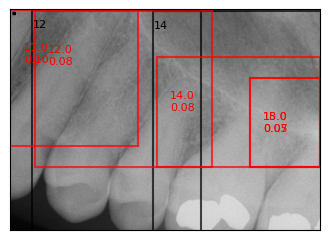

8fb6f1a1_20220322_15.png


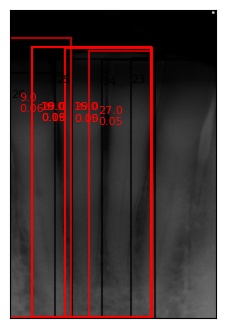

8fb6f1a1_20220322_16.png


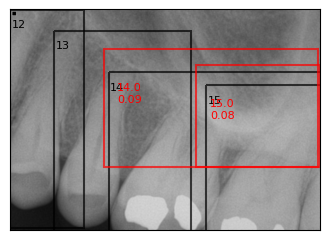

8fb6f1a1_20220322_17.png


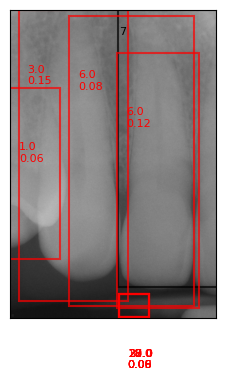

8fb6f1a1_20220322_18.png


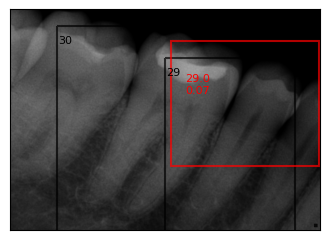

8fb6f1a1_20220322_19.png


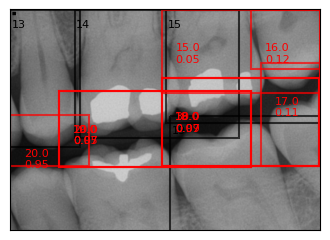

8fb6f1a1_20220322_20.png


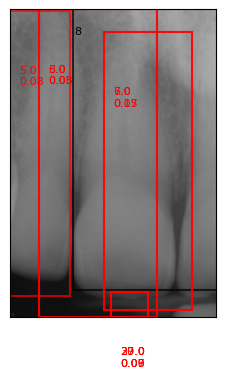

8fb6f1a1_20220322_21.png


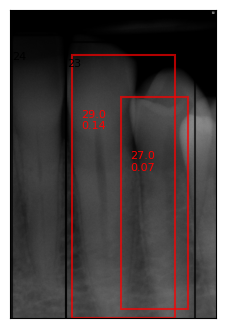

8fb6f1a1_20220322_22.png


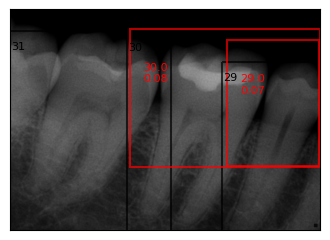

47b57948_20230112_01.png


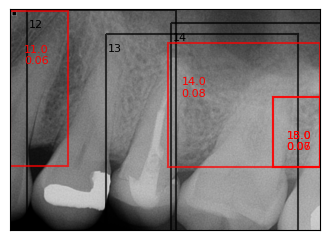

47b57948_20230112_02.png


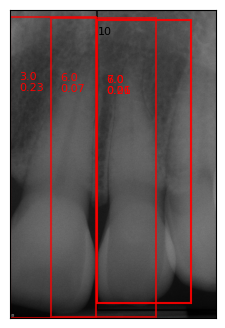

47b57948_20230112_03.png


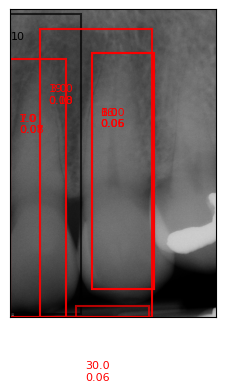

47b57948_20230112_04.png


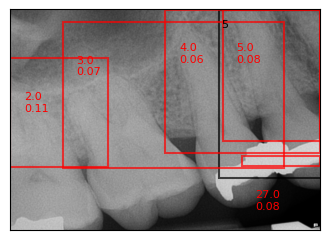

47b57948_20230112_05.png


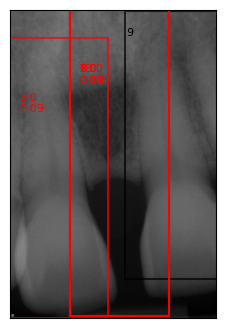

47b57948_20230112_06.png


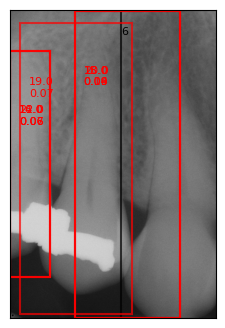

47b57948_20230112_10.png


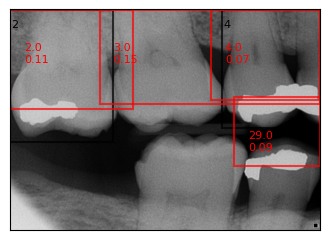

47b57948_20230112_11.png


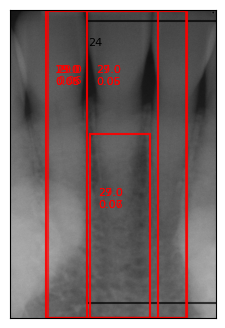

47b57948_20230112_12.png


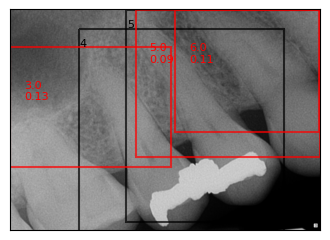

47b57948_20230112_13.png


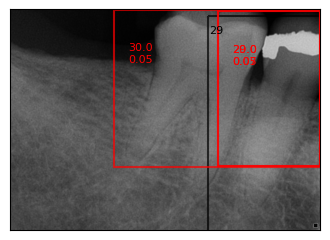

47b57948_20230112_14.png


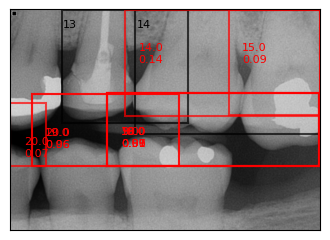

47b57948_20230112_15.png


TypeError: 'float' object is not subscriptable

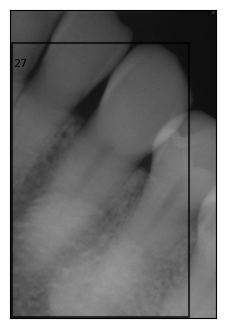

In [85]:
# Show some results
for file_name in file_list[:50]:

    print(file_name)
    file = os.path.join(image_dir, file_name)
    im = ImageData().load_image(file)
    im = ImageData().np2color(im)
    true_df = df.loc[df[file_col] == file_name]
    true_labels = true_df[pos_col].tolist()
    true_bboxes = true_df[bbox_col].tolist()
    
    model_df = pred_df.loc[pred_df['file'] == file_name]
    pred_pos = model_df['pos'].tolist()
    pred_scores = model_df['score'].tolist()
    pred_bboxes = model_df['bbox'].tolist()
    pred_labels = [f'{pos}\n{score:.2f}' for pos, score in zip(pred_pos, pred_scores)]
    
    fig, ax = plt.subplots(figsize=(4, 4))
    ax = plot_boxes(image=im, box_list=true_bboxes, label_list=true_labels, ax=ax, color='k')
    ax = plot_boxes(image=im, box_list=pred_bboxes, label_list=pred_labels, ax=ax, color='r', offset_xy=(100, 200))
    plt.show()